In [1]:
!pip3 install -U ucimlrepo
!pip install -U scikit-learn

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo, list_available_datasets

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
auto_mpg = fetch_ucirepo(id=9)

X = auto_mpg.data.features
y = auto_mpg.data.targets

<!-- Use ONLY initial pfci = 3.78 without later updating / Graph "Without regularization" -->

In [326]:
df_features = pd.DataFrame(X, columns=auto_mpg.data.feature_names)
df_features_new_pfci = pd.DataFrame(X, columns=auto_mpg.data.feature_names)

# initial power factor per cubic inch
pfci = 3.78

# filling missing values with apprx values using (displacement/cylinders) * pfci
df_features['horsepower'] = df_features['horsepower'].fillna((df_features['displacement'] / df_features['cylinders']) * pfci)

<!-- Predict pfci based on already existed data -->

In [332]:
# drop missing values, make df with already known data to calculate pfci
df_known_values = df_features_new_pfci.dropna(subset=['horsepower'])

pfci_array = (df_known_values['horsepower'] * df_known_values['cylinders']) / df_known_values['displacement']
pfci_new = np.mean(np.array(pfci_array))
print(pfci_new)

df_features_new_pfci['horsepower'] = df_features_new_pfci['horsepower'].fillna((df_features_new_pfci['displacement'] / df_features_new_pfci['cylinders']) * pfci_new)

3.10571071801045


In [333]:
x_train, x_temp, y_train, y_temp = train_test_split(df_features, y, test_size = 0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)

x_train_new_pfci, x_temp_new_pfci, y_train_new_pfci, y_temp_new_pfci = train_test_split(df_features_new_pfci, y, test_size = 0.3, random_state=42)
x_val_new_pfci, x_test_new_pfci, y_val_new_pfci, y_test_new_pfci = train_test_split(x_temp_new_pfci, y_temp_new_pfci, test_size = 0.5, random_state=42)

scaler = StandardScaler()
scaler_new_pfci = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

x_train_scaled_new_pfci = scaler_new_pfci.fit_transform(x_train_new_pfci)
x_val_scaled_new_pfci = scaler_new_pfci.transform(x_val_new_pfci)
x_test_scaled_new_pfci = scaler_new_pfci.transform(x_test_new_pfci)

In [334]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

model_new_pfci = LinearRegression()
model_new_pfci.fit(x_train_scaled_new_pfci, y_train_new_pfci)

y_val_predict = model.predict(x_val_scaled)
y_test_predict = model.predict(x_test_scaled)

y_val_predict_new_pfci = model_new_pfci.predict(x_val_scaled_new_pfci)
y_test_predict_new_pfci = model_new_pfci.predict(x_test_scaled_new_pfci)

<!-- Make new my own data to predict target(mpg) -->

In [335]:
x_my_data = np.array([[396.0, 4, 101, 2866, 12.3, 99, 2]])
x_my_data_scaled = scaler.transform(x_my_data)
x_my_data_new_pfci_scaled = scaler_new_pfci.transform(x_my_data)

y_my_data = model.predict(x_my_data_scaled)
y_my_data_new_pfci = model_new_pfci.predict(x_my_data_new_pfci_scaled)

C:\Users\O_O\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\O_O\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<!-- Because this is a very small dataset, I have _test_data >= _train_data and that's why I was trying to make regularization, only for confirmation -->

<!-- Make regularization to prevent overfitting from high-weighted values -->

In [336]:
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(x_train_scaled, y_train)

y_ridge_predict = ridge_reg.predict(x_test_scaled)

In [337]:
# trying to find the best possible value of alpha for Ridge regularization
alphas = np.logspace(-3, 3, 7)
grid_search = GridSearchCV(estimator=ridge_reg, param_grid={'alpha': alphas}, scoring='r2', cv=4)
grid_search.fit(x_train_scaled, y_train)

print(f'Best alpha:{grid_search.best_params_}')
print(f'Best R^2:{grid_search.best_score_}')

Best alpha:{'alpha': 1.0}
Best R^2:0.7970650400062372


<!-- Predicted data score using data without regularization / using iniatial value of pfci -->

initial pfci: 3.78
initial pfci error:9.685036987810044
r2_score: 0.8525868064633747


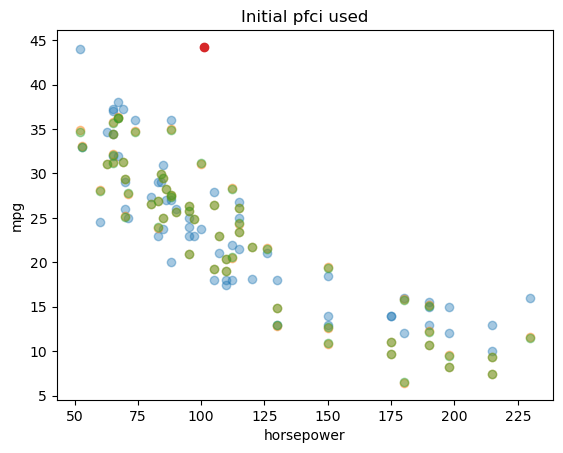

calculated pfci: 3.10571071801045
calculated pfci error:9.702753623978861
r2_score: 0.8523171465829159


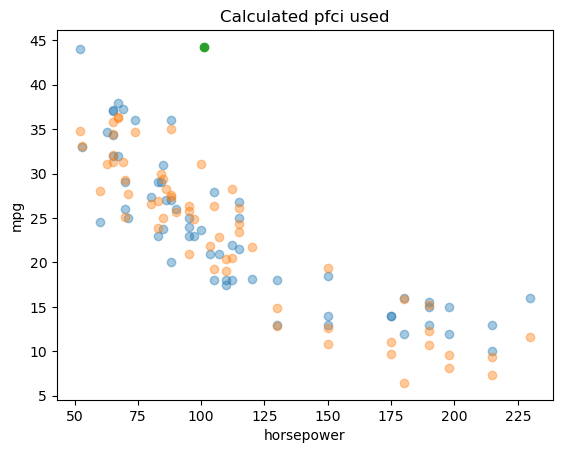

error diff: 0.00026965988045879463


In [349]:
#initial pfci plot
print(f'initial pfci: {pfci}')
print(f'initial pfci error:{mean_squared_error(y_test, y_test_predict)}')
print(f'r2_score: {r2_score(y_test, y_test_predict)}')

plt.scatter(x_test['horsepower'], y_test, alpha=0.4)

plt.scatter(x_test['horsepower'], y_test_predict, alpha=0.4)
plt.scatter(x_test['horsepower'], y_ridge_predict, alpha=0.4)
plt.scatter(x_my_data[0][2], y_my_data, alpha=1)

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Initial pfci used')
plt.show()

# calc pfci plot
print(f'calculated pfci: {pfci_new}')
print(f'calculated pfci error:{mean_squared_error(y_test_new_pfci, y_test_predict_new_pfci)}')
print(f'r2_score: {r2_score(y_test_new_pfci, y_test_predict_new_pfci)}')

plt.scatter(x_test_new_pfci['horsepower'], y_test_new_pfci, alpha=0.4)
plt.scatter(x_test_new_pfci['horsepower'], y_test_predict_new_pfci, alpha=0.4)
plt.scatter(x_my_data[0][2], y_my_data_new_pfci, alpha=1)

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Calculated pfci used')
plt.show()

print(f'error diff: {(r2_score(y_test, y_test_predict)) - (r2_score(y_test_new_pfci, y_test_predict_new_pfci))}')

<!-- Random forest implementation -->

In [272]:
# based on df that using calculater pfci for more accurate and logic prediction
df_dt_features = df_features_new_pfci


displacement  cylinders  horsepower  weight  acceleration  model_year  origin
False         False      False       False   False         False       False     398
Name: count, dtype: int64
